In [163]:
import os
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import pickle
from scipy.stats import uniform

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

import warnings

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *


# Preparación de los datos

In [27]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Ruido_diario_acumulado.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [28]:
# Se obtienen los datos
df_acoustics = pd.read_csv('data/raw/Ruido_diario_acumulado.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


389519

In [29]:
# Se borran los datos no necesarios
df_acoustics = df_acoustics.drop(columns=['LAEQ', 'LAS01', 'LAS10', 'LAS90', 'LAS99'])

df_acoustics.head()


,NMT,anio,mes,dia,tipo,LAS50
0,3,2014,1,1,D,"54,3"
1,3,2014,1,1,E,56
2,3,2014,1,1,N,"60,9"
3,3,2014,1,1,T,"56,5"
4,4,2014,1,1,D,"63,2"


In [30]:
# Se mantiene solo el tipo "T", que representa el total del día
df_acoustics = df_acoustics.drop(df_acoustics[df_acoustics['tipo'] != 'T'].index)

df_acoustics = df_acoustics.drop(columns='tipo')

df_acoustics.head()


,NMT,anio,mes,dia,LAS50
3,3,2014,1,1,"56,5"
7,4,2014,1,1,"63,9"
11,5,2014,1,1,"58,6"
15,8,2014,1,1,"65,2"
19,10,2014,1,1,"58,7"


In [31]:
for date in df_acoustics.columns[1:-1]:
    df_acoustics[date] = list(map(str, df_acoustics[date]))

df_acoustics['date'] = df_acoustics['anio'] + '-' + df_acoustics['mes'] + '-' + df_acoustics['dia']

df_acoustics = df_acoustics.drop(columns=['anio', 'mes', 'dia'])

df_acoustics.head()


,NMT,LAS50,date
3,3,"56,5",2014-1-1
7,4,"63,9",2014-1-1
11,5,"58,6",2014-1-1
15,8,"65,2",2014-1-1
19,10,"58,7",2014-1-1


In [32]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['date'] = pd.to_datetime(df_acoustics['date'])

df_acoustics = df_acoustics.set_index('date')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20'],
              dtype='datetime64[ns]', name='date', length=97522, freq=None)

In [33]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics['LAS50'] = df_acoustics['LAS50'].astype(str)

for col in df_acoustics.columns[1:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = pd.to_numeric(df_acoustics[col], errors='coerce')
    df_acoustics[col] = df_acoustics[col].astype(float)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97522 entries, 2014-01-01 to 2023-03-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NMT     97522 non-null  int64  
 1   LAS50   97522 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [34]:
# Se pivota la tabla para que cada columna sea una zona
df_acoustics = df_acoustics.pivot_table(index='date', columns='NMT', values='LAS50')

df_acoustics.head()


NMT,1,2,3,4,5,6,8,10,11,12,...,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,56.5,63.9,58.6,NaN,65.2,58.7,65.4,60.3,...,60.0,49.0,51.9,52.6,47.8,60.3,NaN,56.2,48.1,50.5
2014-01-02,NaN,NaN,58.0,64.8,60.0,NaN,67.5,61.7,69.1,62.7,...,62.8,51.2,59.7,58.9,51.0,62.7,NaN,60.9,51.6,54.3
2014-01-03,NaN,NaN,58.6,64.7,60.0,NaN,67.2,61.9,69.1,62.4,...,63.5,52.6,58.5,58.9,50.5,62.7,NaN,60.6,50.9,54.0
2014-01-04,NaN,NaN,59.0,64.2,59.3,NaN,67.1,60.3,67.4,61.7,...,61.9,50.4,55.8,60.0,51.1,62.0,NaN,60.1,50.9,52.8
2014-01-05,NaN,NaN,58.0,63.4,57.8,NaN,64.9,58.9,66.1,60.5,...,59.8,48.7,52.7,56.9,47.1,60.1,NaN,58.3,47.9,50.5


In [35]:
# Se establece la frecuencia "D" (diaria)
df_acoustics = df_acoustics.asfreq('D')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       2820 non-null   float64
 1   2       2902 non-null   float64
 2   3       3243 non-null   float64
 3   4       2456 non-null   float64
 4   5       3279 non-null   float64
 5   6       2884 non-null   float64
 6   8       3218 non-null   float64
 7   10      3254 non-null   float64
 8   11      3206 non-null   float64
 9   12      3276 non-null   float64
 10  13      3274 non-null   float64
 11  14      3209 non-null   float64
 12  16      3190 non-null   float64
 13  17      3261 non-null   float64
 14  18      3257 non-null   float64
 15  19      3168 non-null   float64
 16  20      3234 non-null   float64
 17  24      3246 non-null   float64
 18  25      2869 non-null   float64
 19  26      2869 non-null   float64
 20  27      3216 non-null   float64
 21  28      327

In [36]:
# El resto, con una interpolación. Sigue habiendo nulos
df_acoustics = df_acoustics.interpolate(method='spline', order=3)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3001 non-null   float64
 1   2       3000 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3000 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3001 non-null   float64
 19  26      3001 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

In [37]:
# Se imputan los restantes con los vecinos cercanos
imputer = KNNImputer(n_neighbors=5)

imputer.fit(df_acoustics)

df_acoustics = pd.DataFrame(imputer.transform(df_acoustics), columns=df_acoustics.columns, index=df_acoustics.index)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3366 non-null   float64
 1   2       3366 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3366 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3366 non-null   float64
 19  26      3366 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

# ML

## Preparación

In [76]:
# Se crea un dataframe donde el índice es cada zona
new_df = pd.DataFrame(index=df_acoustics.columns, columns=df_acoustics.index)

for col in df_acoustics.columns:
    for row in df_acoustics.index:
        new_df.loc[col, row] = df_acoustics.loc[row, col]

new_df.head()


date,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2023-03-11,2023-03-12,2023-03-13,2023-03-14,2023-03-15,2023-03-16,2023-03-17,2023-03-18,2023-03-19,2023-03-20
NMT,,,,,,,,,,,,,,,,,,,,,
1,64.6,66.62,66.82,65.66,64.26,64.44,65.838602,65.64,65.96,66.06,...,61.6,60.3,61.0,61.3,61.9,62.0,62.0,60.6,59.0,58.5
2,66.78,69.28,69.12,68.54,67.22,66.84,68.233943,68.34,68.16,68.38,...,63.8,62.3,64.0,63.8,64.0,64.0,64.3,63.1,61.7,61.9
3,56.5,58.0,58.6,59.0,58.0,55.7,57.3,56.6,56.7,57.3,...,61.3,59.0,58.6,58.6,58.7,58.6,58.4,58.3,57.5,55.8
4,63.9,64.8,64.7,64.2,63.4,63.1,64.1,64.2,64.4,64.8,...,60.1,59.0,59.0,58.3,58.8,59.0,59.3,58.9,58.7,57.5
5,58.6,60.0,60.0,59.3,57.8,57.1,59.2,59.1,59.1,59.8,...,57.160822,57.130517,57.098419,57.064454,57.028545,56.990617,59.4,56.8,56.0,56.1


In [87]:
# Se pasan los valores a "float"
new_df = new_df.astype(float)


## Baseline

### Target: 2023

In [77]:
# Se establecen los modelos que se quieren probar
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'SVR': '',
 'XGBRegressor': ''}

In [138]:
# Se eligen las fechas del 2023 para test
cols_2023 = new_df.columns[-79:]


In [139]:
# Se lanza el "baseline"
baseline = Regression(new_df, cols_2023)
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 1.02 sec(s). Total time: 1.02
Starting Ridge:
- Ridge done in 0.6 sec(s). Total time: 1.62
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.58 sec(s). Total time: 2.2
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.93 sec(s). Total time: 3.13
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 30.64 sec(s). Total time: 33.78
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 117.21 sec(s). Total time: 150.98


,LinearRegression,Ridge,KNeighborsRegressor,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,1.269383,1.270201,2.580193,2.633070,2.212864,2.322556,LinearRegression,DecisionTreeRegressor: random_state=43
mse,1.865577,1.867026,7.406862,7.568406,5.354806,5.880467,LinearRegression,DecisionTreeRegressor: random_state=43
mae,1.069101,1.069546,2.114834,2.316040,1.786065,1.982570,LinearRegression,DecisionTreeRegressor: random_state=43
r2_score,0.900839,0.900809,0.633405,0.593539,0.710393,0.598727,LinearRegression,XGBRegressor: random_state=43
mape,0.018969,0.018976,0.038110,0.041323,0.032000,0.034746,LinearRegression,DecisionTreeRegressor: random_state=43


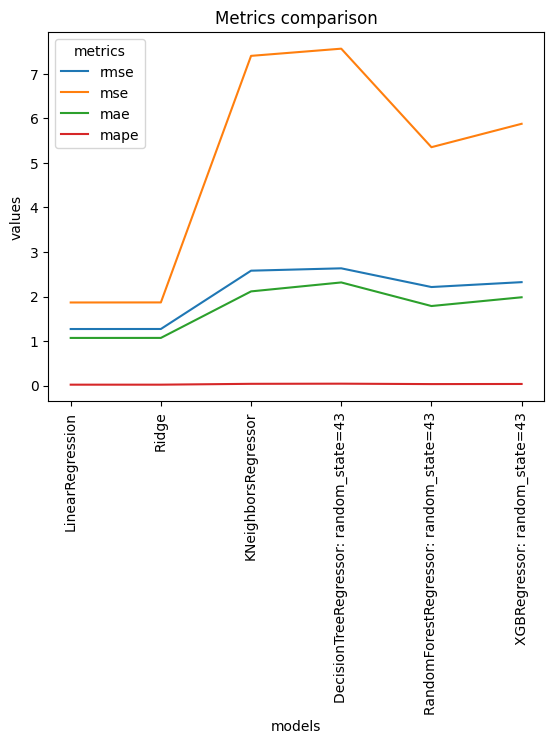

In [140]:
# Se visualizan los resultados. Ridge es el mejor, ya que la relación es lineal y las variables están bastante correlacionadas
baseline.visualize('rmse', 'mse', 'mae', 'mape')


#### Selección de hiperparámetros

In [169]:
def calculate_rmse(y_test, y_pred):
    '''Returns root mean squared error'''
    '''Requires from sklearn.metrics import mean_squared_error'''
    return mean_squared_error(y_test, y_pred, squared=False)


In [178]:
warnings.filterwarnings("ignore")

kfolds = KFold(n_splits=5, shuffle=True, random_state=43)
rmse = make_scorer(calculate_rmse, greater_is_better=False)

model = Ridge()

params = {'fit_intercept': [True, False],
            'alpha': np.linspace(1, 100, num=100),
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    cv=kfolds,
                    verbose=4
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END ....alpha=1.0, fit_intercept=True;, score=-1.534 total time=   0.0s
[CV 2/5] END ....alpha=1.0, fit_intercept=True;, score=-1.530 total time=   0.0s
[CV 3/5] END ....alpha=1.0, fit_intercept=True;, score=-1.388 total time=   0.1s
[CV 4/5] END ....alpha=1.0, fit_intercept=True;, score=-0.730 total time=   0.1s
[CV 5/5] END ....alpha=1.0, fit_intercept=True;, score=-1.169 total time=   0.0s
[CV 1/5] END ...alpha=1.0, fit_intercept=False;, score=-1.535 total time=   0.0s
[CV 2/5] END ...alpha=1.0, fit_intercept=False;, score=-1.475 total time=   0.0s
[CV 3/5] END ...alpha=1.0, fit_intercept=False;, score=-1.235 total time=   0.0s
[CV 4/5] END ...alpha=1.0, fit_intercept=False;, score=-0.815 total time=   0.0s
[CV 5/5] END ...alpha=1.0, fit_intercept=False;, score=-1.188 total time=   0.0s
[CV 1/5] END ....alpha=2.0, fit_intercept=True;, score=-1.534 total time=   0.0s
[CV 2/5] END ....alpha=2.0, fit_intercept=Tru

In [180]:
# Estas son las mejores métricas posibles
print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'mae: {mean_absolute_error(y_test,y_pred)}')
print(f'r2: {r2_score(y_test, y_pred)}')
print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')


rmse: 3.065898130697232
mse: 12.191545022317841
mae: 1.4827410433712738
r2: 0.8173955273828885
mape: 0.023076166872818955


### Target: una sola fecha

In [186]:
# Se lanza el "baseline"
baseline = Regression(new_df, '2023-03-20')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43']
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.65 sec(s). Total time: 0.65
Starting Ridge:
- Ridge done in 0.58 sec(s). Total time: 1.22
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.54 sec(s). Total time: 1.77
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.72 sec(s). Total time: 2.49
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 16.0 sec(s). Total time: 18.49
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 16.75 sec(s). Total time: 35.25


,LinearRegression,Ridge,KNeighborsRegressor,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,0.797858,0.799789,2.702677,2.578100,2.168538,2.387618,LinearRegression,KNeighborsRegressor
mse,0.661254,0.661939,7.539400,7.075900,4.851653,6.349748,LinearRegression,KNeighborsRegressor
mae,0.657825,0.656647,2.415600,2.095000,1.821000,1.975811,Ridge,KNeighborsRegressor
r2_score,0.946010,0.946648,0.540390,0.488314,0.677752,0.572995,Ridge,XGBRegressor: random_state=43
mape,0.012070,0.012061,0.043946,0.038423,0.033043,0.035100,Ridge,KNeighborsRegressor


#### Selección de hiperparámetros

In [187]:
warnings.filterwarnings("ignore")

kfolds = KFold(n_splits=5, shuffle=True, random_state=43)
rmse = make_scorer(calculate_rmse, greater_is_better=False)

model = Ridge()

params = {'fit_intercept': [True, False],
            'alpha': np.linspace(1, 100, num=100),
            }

grid = GridSearchCV(estimator=model,
                    param_grid=params,
                    scoring=rmse,
                    cv=kfolds,
                    verbose=4
                    )

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END ....alpha=1.0, fit_intercept=True;, score=-0.741 total time=   0.0s
[CV 2/5] END ....alpha=1.0, fit_intercept=True;, score=-0.978 total time=   0.0s
[CV 3/5] END ....alpha=1.0, fit_intercept=True;, score=-0.557 total time=   0.0s
[CV 4/5] END ....alpha=1.0, fit_intercept=True;, score=-0.930 total time=   0.0s
[CV 5/5] END ....alpha=1.0, fit_intercept=True;, score=-0.793 total time=   0.0s
[CV 1/5] END ...alpha=1.0, fit_intercept=False;, score=-0.739 total time=   0.0s
[CV 2/5] END ...alpha=1.0, fit_intercept=False;, score=-0.878 total time=   0.0s
[CV 3/5] END ...alpha=1.0, fit_intercept=False;, score=-0.569 total time=   0.0s
[CV 4/5] END ...alpha=1.0, fit_intercept=False;, score=-0.922 total time=   0.0s
[CV 5/5] END ...alpha=1.0, fit_intercept=False;, score=-0.792 total time=   0.0s
[CV 1/5] END ....alpha=2.0, fit_intercept=True;, score=-0.741 total time=   0.0s
[CV 2/5] END ....alpha=2.0, fit_intercept=Tru

In [189]:
# Estas son las mejores métricas posibles
print(f'rmse: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'mse: {mean_squared_error(y_test, y_pred)}')
print(f'mae: {mean_absolute_error(y_test,y_pred)}')
print(f'r2: {r2_score(y_test, y_pred)}')
print(f'mape: {mean_absolute_percentage_error(y_test, y_pred)}')


rmse: 1.465251912170318
mse: 2.1469631661187734
mae: 0.9117477999509255
r2: 0.9276395611074076
mape: 0.017251504163803316


## Modelaje

In [216]:
last_column = str(new_df.columns[-1]).split()[0]
X = new_df.drop(columns=last_column)
y = new_df[last_column]

X.head()


date,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2023-03-10,2023-03-11,2023-03-12,2023-03-13,2023-03-14,2023-03-15,2023-03-16,2023-03-17,2023-03-18,2023-03-19
NMT,,,,,,,,,,,,,,,,,,,,,
1,64.60,66.62,66.82,65.66,64.26,64.44,65.838602,65.64,65.96,66.06,...,62.20000,61.600000,60.300000,61.000000,61.300000,61.900000,62.000000,62.0,60.6,59.0
2,66.78,69.28,69.12,68.54,67.22,66.84,68.233943,68.34,68.16,68.38,...,64.70000,63.800000,62.300000,64.000000,63.800000,64.000000,64.000000,64.3,63.1,61.7
3,56.50,58.00,58.60,59.00,58.00,55.70,57.300000,56.60,56.70,57.30,...,59.80000,61.300000,59.000000,58.600000,58.600000,58.700000,58.600000,58.4,58.3,57.5
4,63.90,64.80,64.70,64.20,63.40,63.10,64.100000,64.20,64.40,64.80,...,60.30000,60.100000,59.000000,59.000000,58.300000,58.800000,59.000000,59.3,58.9,58.7
5,58.60,60.00,60.00,59.30,57.80,57.10,59.200000,59.10,59.10,59.80,...,57.18941,57.160822,57.130517,57.098419,57.064454,57.028545,56.990617,59.4,56.8,56.0


In [ ]:
for i in range(10):
    last_column = str(new_df.columns[-1]).split()[0]
    X = new_df.drop(columns=last_column)
    y = new_df[last_column]
